In [1]:
import pandas as pd
import numpy as np
from torch import nn, optim
import torch
import matplotlib.pyplot as plt

In [2]:
config = {
    'epoch': 1000,
    'batch_size': 512,
    'learning_rate': 8e-3,
    'device': 'cuda',
    "num_cols": ['regDate', 'creatDate', 'power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10',
                 'v_11', 'v_12', 'v_13', 'v_14'],
    "cate_cols": ['model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'seller', 'notRepairedDamage']
}

In [3]:
test_data = pd.read_csv('used_car_testB_20200421.csv', sep=' ')
test_data.shape

(50000, 30)

In [4]:
# 导入数据
train_data = pd.read_csv('used_car_train_20200313.csv', sep=' ')
train_data.shape

(150000, 31)

In [5]:
# 合并数据
data = pd.concat([train_data, test_data])
data.shape

(200000, 31)

In [6]:
# 定义One-Hot编码函数
def oneHotEncode(df, colNames):
    for col in colNames:
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dummies],axis=1)
        df.drop([col], axis=1, inplace=True)
    return df

In [7]:
data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [8]:
data = data.replace('-', '-1')
data.notRepairedDamage = data.notRepairedDamage.astype('float32')
data.loc[data['power']>600,'power'] = 600

In [9]:
# 处理离散数据
for col in config['cate_cols']:
    data[col] = data[col].fillna('-1')
data = oneHotEncode(data, config['cate_cols'])

# 处理连续数据
for col in config['num_cols']:
    data[col] = data[col].fillna(0)
    data[col] = (data[col]-data[col].min()) / (data[col].max()-data[col].min())

# 处理(可能)无关数据 
data.drop(['name', 'regionCode'], axis=1, inplace=True)

data.columns

Index(['SaleID', 'regDate', 'power', 'kilometer', 'offerType', 'creatDate',
       'price', 'v_0', 'v_1', 'v_2',
       ...
       'fuelType_6.0', 'fuelType_-1', 'gearbox_0.0', 'gearbox_1.0',
       'gearbox_-1', 'seller_0', 'seller_1', 'notRepairedDamage_-1.0',
       'notRepairedDamage_0.0', 'notRepairedDamage_1.0'],
      dtype='object', length=336)

In [10]:
# 暂存处理后的test数据集
test_data = data[pd.isna(data.price)]
test_data.to_csv('./one_hot_testB.csv')

In [11]:
# 删除test数据(price is nan)
data.reset_index(inplace=True)
train_data = data
train_data = train_data.drop(data[pd.isna(data.price)].index)
train_data.shape

(150000, 337)

In [12]:
# 删除ID
train_data.drop(['SaleID'], axis=1, inplace=True)
# 打乱
train_data = train_data.sample(frac=1)

In [13]:
train_data.shape

(150000, 336)

In [14]:
# 分离目标
train_target = train_data['price']
train_data.drop(['price', 'index'], axis=1, inplace=True)

In [15]:
# 分离出验证集，用于观察拟合情况
validation_data = train_data[:10000]
train_data = train_data[10000:]
validation_target = train_target[:10000]
train_target = train_target[10000:]

In [16]:
validation_data.shape, train_data.shape, validation_target.shape, train_target.shape

((10000, 334), (140000, 334), (10000,), (140000,))

In [17]:
train_data.columns

Index(['regDate', 'power', 'kilometer', 'offerType', 'creatDate', 'v_0', 'v_1',
       'v_2', 'v_3', 'v_4',
       ...
       'fuelType_6.0', 'fuelType_-1', 'gearbox_0.0', 'gearbox_1.0',
       'gearbox_-1', 'seller_0', 'seller_1', 'notRepairedDamage_-1.0',
       'notRepairedDamage_0.0', 'notRepairedDamage_1.0'],
      dtype='object', length=334)

In [18]:
# 定义网络结构
class Network(nn.Module):
    def __init__(self, in_dim, hidden_1, hidden_2, hidden_3, hidden_4):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, hidden_1),
            nn.BatchNorm1d(hidden_1),
            nn.ReLU(),
            nn.Linear(hidden_1, hidden_2),
            nn.BatchNorm1d(hidden_2),
            nn.ReLU(),
            nn.Linear(hidden_2, hidden_3),
            nn.BatchNorm1d(hidden_3),
            nn.ReLU(),
            nn.Linear(hidden_3, hidden_4),
            nn.BatchNorm1d(hidden_4),
            nn.ReLU(),
            nn.Linear(hidden_4, 1)
        )

    def forward(self, x):
        y = self.layers(x)
        return y

In [19]:
# 定义网络
model = Network(train_data.shape[1], 256, 256, 256, 32)
model.to(config['device'])

# 使用Xavier初始化权重
for line in model.layers:
    if type(line) == nn.Linear:
        print(line)
        nn.init.xavier_uniform_(line.weight)

Linear(in_features=334, out_features=256, bias=True)
Linear(in_features=256, out_features=256, bias=True)
Linear(in_features=256, out_features=256, bias=True)
Linear(in_features=256, out_features=32, bias=True)
Linear(in_features=32, out_features=1, bias=True)


In [20]:
# 将数据转化为tensor，并移动到cpu或cuda上

for u in train_data.columns:
    if train_data[u].dtype==bool:
        train_data[u]=train_data[u].astype('int')

for u in validation_data.columns:
    if validation_data[u].dtype==bool:
        validation_data[u]=validation_data[u].astype('int')

train_features = torch.tensor(train_data.values, dtype=torch.float32, device=config['device'])
train_num = train_features.shape[0]
train_labels = torch.tensor(train_target.values, dtype=torch.float32, device=config['device'])

validation_features = torch.tensor(validation_data.values, dtype=torch.float32, device=config['device'])
validation_num = validation_features.shape[0]
validation_labels = torch.tensor(validation_target.values, dtype=torch.float32, device=config['device'])

In [21]:
# 特征长度
train_features[1].shape

torch.Size([334])

In [22]:
# 定义损失函数和优化器
criterion = nn.MSELoss()
criterion.to(config['device'])
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

In [23]:
# 开始训练

mae_list = []

for epoch in range(config['epoch']):
    losses = []
    model.train()
    for i in range(0, train_num, config['batch_size']):
        end = i + config['batch_size']
        if i + config['batch_size'] > train_num-1:
            end = train_num-1
        mini_batch = train_features[i: end]
        mini_batch_label = train_labels[i: end]
        pred = model(mini_batch)
        pred = pred.squeeze()
        loss = criterion(pred, mini_batch_label)

        if torch.isnan(loss):
            break
        mae = torch.abs(mini_batch_label-pred).sum()/(end-i)
        losses.append(mae.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    pred = model(validation_features)
    validation_mae = torch.abs(validation_labels-pred.squeeze()).sum().item()/validation_num
    
    mae_list.append((sum(losses)/len(losses), validation_mae))
        
    print(f"epoch:{epoch + 1} MAE: {sum(losses)/len(losses)}, Validation_MAE: {validation_mae}")
    torch.save(model, 'model.pth')

epoch:1 MAE: 5834.069341283645, Validation_MAE: 5560.1592
epoch:2 MAE: 5165.48685917541, Validation_MAE: 4505.214
epoch:3 MAE: 3911.2785564339074, Validation_MAE: 3092.0702
epoch:4 MAE: 2520.0448724231583, Validation_MAE: 1884.6544
epoch:5 MAE: 1458.2930121874288, Validation_MAE: 1235.8848
epoch:6 MAE: 940.3370971679688, Validation_MAE: 890.1161
epoch:7 MAE: 793.9903649100422, Validation_MAE: 710.2266
epoch:8 MAE: 751.3141369227945, Validation_MAE: 624.48535
epoch:9 MAE: 728.4320496050981, Validation_MAE: 610.9707
epoch:10 MAE: 712.5023142125485, Validation_MAE: 592.5786
epoch:11 MAE: 703.3500415217268, Validation_MAE: 597.31835
epoch:12 MAE: 697.6668305779896, Validation_MAE: 585.7233
epoch:13 MAE: 688.1951756164106, Validation_MAE: 625.2108
epoch:14 MAE: 683.9965457220147, Validation_MAE: 614.74995
epoch:15 MAE: 675.6524224942618, Validation_MAE: 626.95025
epoch:16 MAE: 670.8585564829137, Validation_MAE: 608.25405
epoch:17 MAE: 660.7693665219049, Validation_MAE: 620.2217
epoch:18 MAE

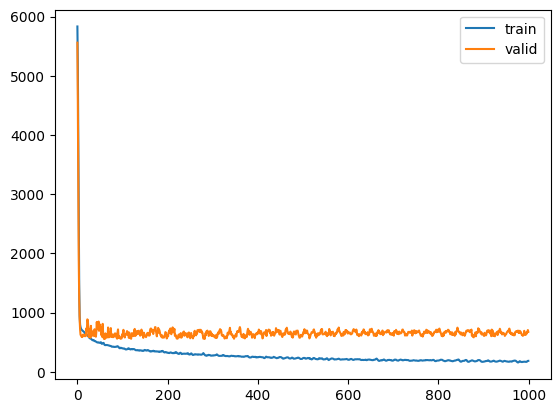

In [24]:
x = np.arange(0, config['epoch'])
y1, y2 = zip(*mae_list)
plt.plot(x, y1, label='train')
plt.plot(x, y2, label='valid')
plt.legend()
plt.show()